### Deep learning
This notebook implements a five-fold cross-validation model selection pipeline for deep learning algorithms. Once the best model has been selected, it is trained on the entire dataset with five buoy tracks withheld for validation and evaluation of model prediction accuracy.

Package imports

In [1]:
# Core Libraries
import gc
import glob
import math
import os
import time
from datetime import datetime, timedelta

# Data Handling
import netCDF4 as nc
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Geospatial Calculations
from geopy import Point
from geopy.distance import great_circle
from haversine import haversine
from scipy.spatial import cKDTree

# Machine Learning Models
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    VotingRegressor
)
from sklearn.linear_model import (
    BayesianRidge,
    ElasticNet,
    Lasso,
    LinearRegression,
    Ridge
)
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

# Model Evaluation and Optimization
import optuna
from optuna import create_study
from scipy.stats import randint, uniform
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
from sklearn.model_selection import (
    GroupKFold,
    KFold,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split
)

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import tensorflow as tf
import time
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import tensorflow as tf
import time
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

c:\Users\benem\anaconda3\envs\mlggeo2024_aobuoypredict\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Function to pre-process spatial data

In [2]:
# Precompute the KDTree and valid_time differences
def precompute_kdtree_and_time_diffs(uwnd_nc_file_path):
    try:
        print("Precomputing KDTree and time differences...")
        # Load the NetCDF file
        ds = nc.Dataset(uwnd_nc_file_path)

        # Extract the valid_time, latitudes, and longitudes from the NetCDF file
        valid_time = ds.variables['valid_time'][:]  # Assuming 'valid_time' is the variable name for time
        latitudes = ds.variables['latitude'][:]
        longitudes = ds.variables['longitude'][:]

        # Convert valid_time from seconds since 1970-01-01 to datetime
        base_time = datetime(1970, 1, 1)
        valid_time_dt = np.array([base_time + timedelta(seconds=int(ts)) for ts in valid_time], dtype='datetime64[ns]')

        # Create a KDTree for fast spatial lookup
        lat_lon_pairs = np.array([(lat, lon) for lat in latitudes for lon in longitudes])
        tree = cKDTree(lat_lon_pairs)

        print("KDTree and time differences precomputed successfully.")
        return tree, valid_time_dt, latitudes, longitudes, lat_lon_pairs
    except Exception as e:
        print(f"Error precomputing KDTree and time differences: {e}")
        raise

uwnd_nc_file_path = '../data/raw/reanalyses/ERA5/era5_uwnd_2023.nc'
vwnd_nc_file_path = '../data/raw/reanalyses/ERA5/era5_vwnd_2023.nc'
try:
    tree, valid_time_dt, latitudes, longitudes, lat_lon_pairs = precompute_kdtree_and_time_diffs(uwnd_nc_file_path)
except Exception as e:
    print(f"Error precomputing KDTree and time differences: {e}")
    raise

Precomputing KDTree and time differences...
KDTree and time differences precomputed successfully.


Function to extract wind components at a given lat/lon (preloads reanalysis netCDFs also)

In [3]:
uwnd_nc_file_path = '../data/raw/reanalyses/ERA5/era5_uwnd_2023.nc'
vwnd_nc_file_path = '../data/raw/reanalyses/ERA5/era5_vwnd_2023.nc'

uwnd_ds = nc.Dataset(uwnd_nc_file_path)
vwnd_ds = nc.Dataset(vwnd_nc_file_path)

uwnd_array = uwnd_ds.variables['u'][:, 0, :, :]  # Assuming 'u' is the variable name for u-component wind and removing the pressure dimension
vwnd_array = vwnd_ds.variables['v'][:, 0, :, :]  # Assuming 'v' is the variable name for v-component wind and removing the pressure dimension

# Function to extract wind components
def extract_wind_components(lat, lon, dt, tree, valid_time_dt, latitudes, longitudes, lat_lon_pairs):
    try:
        # Convert the given datetime to a numpy datetime64 object
        row_datetime = np.datetime64(dt)

        # Find the value in the valid_time dimension closest in time to the datetime in the dataframe
        time_diffs = np.abs(valid_time_dt - row_datetime)
        closest_time_index = np.argmin(time_diffs)

        # Check if the calculated index is within the bounds of the uwnd_array
        if closest_time_index < 0 or closest_time_index >= uwnd_array.shape[0]:
            raise ValueError("The given datetime is out of bounds for the NetCDF data")

        # Select the corresponding netCDF slices
        uwnd_slice = uwnd_array[closest_time_index, :, :]
        vwnd_slice = vwnd_array[closest_time_index, :, :]

        # Find the grid cell of the netCDF slice closest to the given Latitude and Longitude position
        lat_lon = (lat, lon)
        _, closest_point_index = tree.query(lat_lon)
        closest_lat, closest_lon = lat_lon_pairs[closest_point_index]

        # Find the index of the closest latitude/longitude pair in the arrays
        lat_index = np.where(latitudes == closest_lat)[0][0]
        lon_index = np.where(longitudes == closest_lon)[0][0]

        # Extract the u and v wind components
        u_wind = uwnd_slice[lat_index, lon_index]
        v_wind = vwnd_slice[lat_index, lon_index]

        # Round wind components to 4 decimal places
        u_wind = round(u_wind, 4)
        v_wind = round(v_wind, 4)

        return u_wind, v_wind
    except Exception as e:
        print(f"Error extracting wind components: {e}")
        raise

Function to calculate new position from current position, displacement, and heading

In [4]:
# Import the math module
import math

# Redefine the calculate_new_position function with wrapping logic
def calculate_new_position(current_position, displacement, heading):
    R = 6371000  # Earth's radius in meters
    
    # Convert inputs to radians
    lat1 = math.radians(current_position[0])
    lon1 = math.radians(current_position[1])
    heading_rad = math.radians(heading)
    
    # Compute new latitude
    lat2 = math.asin(math.sin(lat1) * math.cos(displacement / R) +
                     math.cos(lat1) * math.sin(displacement / R) * math.cos(heading_rad))
    
    # Compute new longitude
    lon2 = lon1 + math.atan2(math.sin(heading_rad) * math.sin(displacement / R) * math.cos(lat1),
                             math.cos(displacement / R) - math.sin(lat1) * math.sin(lat2))
    
    # Convert back to degrees
    new_lat = math.degrees(lat2)
    new_lon = math.degrees(lon2)
    
    # Wrap longitude to [-180, 180]
    if new_lon > 180:
        new_lon -= 360
    elif new_lon < -180:
        new_lon += 360
    
    return new_lat, new_lon


Iterative predictor function

In [13]:
def iterative_prediction(val_data, model, tree, valid_times, latitudes, longitudes, lat_lon_pairs):
    """
    Performs iterative prediction for each buoy in the validation data.
    Returns:
        A DataFrame of predictions with columns: 
        'True Latitude', 'True Longitude', 'Predicted Latitude', 'Predicted Longitude', 'Datetime', and 'BuoyID'.
    """

    # Initialize a list to store predictions for all buoys
    all_predictions = []

    # Iterate over each unique BuoyID
    unique_buoy_ids = val_data['BuoyID'].unique()
    for buoy_id in unique_buoy_ids:
        # Extract data for the current buoy
        buoy_data = val_data[val_data['BuoyID'] == buoy_id].reset_index(drop=True)

        # Initialize predictions for the current buoy
        predictions = []

        # Extract initial conditions for the current buoy
        current_lat, current_lon = buoy_data.iloc[0][['Latitude', 'Longitude']]
        current_uwnd, current_vwnd = buoy_data.iloc[0][['era5_uwnd', 'era5_vwnd']]

        # Iterate through each row of the buoy's data
        for i in range(len(buoy_data)):
            next_row = buoy_data.iloc[i]

            # Prepare input data for prediction
            input_data = pd.DataFrame({
                'Latitude': [current_lat],
                'Longitude': [current_lon],
                'era5_uwnd': [current_uwnd],
                'era5_vwnd': [current_vwnd]
            })

            # Make prediction for displacement and heading
            predicted_displacement, predicted_heading = model.predict(input_data, verbose=0)[0]

            # Calculate new position based on the predictions
            predicted_lat, predicted_lon = calculate_new_position(
                (current_lat, current_lon),
                predicted_displacement,
                predicted_heading
            )

            # Extract wind components at the predicted position and time
            predicted_wind_u, predicted_wind_v = extract_wind_components(
                predicted_lat,
                predicted_lon,
                next_row['datetime'],
                tree,
                valid_times,
                latitudes,
                longitudes,
                lat_lon_pairs
            )

            # Save the prediction
            predictions.append({
                'BuoyID': buoy_id,
                'Datetime': next_row['datetime'],
                'True Latitude': next_row['Latitude'],  # Add the true latitude
                'True Longitude': next_row['Longitude'],  # Add the true longitude
                'Predicted Latitude': predicted_lat,
                'Predicted Longitude': predicted_lon
            })

            # Update current state for the next iteration
            current_lat, current_lon = predicted_lat, predicted_lon
            current_uwnd, current_vwnd = predicted_wind_u, predicted_wind_v

        # Append predictions for the current buoy
        all_predictions.extend(predictions)

    # Convert predictions to a DataFrame for easier handling
    predictions_df = pd.DataFrame(all_predictions)
    return predictions_df

In [15]:
import os
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Conv1D, Flatten, LSTM
from tensorflow.keras.optimizers import Adam

# Define a physics-informed loss function
def physics_informed_loss(y_true, y_pred):
    true_displacement = y_true[:, 0]
    pred_displacement = y_pred[:, 0]
    true_energy = 0.5 * tf.square(true_displacement)
    pred_energy = 0.5 * tf.square(pred_displacement)
    energy_loss = tf.reduce_mean(tf.abs(true_energy - pred_energy))  # Physical constraint
    mse_loss = tf.keras.losses.MeanSquaredError()(y_true, y_pred)  # Standard MSE loss
    total_loss = mse_loss + 0.1 * energy_loss  # Weighted combination
    return total_loss

# Load the data
print("Loading data...")
buoy_data = pd.read_csv('../combined_buoy_data.csv')
print("Data loaded successfully!")

# Preprocess the data
columns_to_keep = ['Latitude', 'Longitude', 'BuoyID', 'datetime', 'era5_uwnd', 'era5_vwnd', 'displacement', 'heading']
buoy_data = buoy_data[columns_to_keep].copy()
buoy_data['datetime'] = pd.to_datetime(buoy_data['datetime'])

# Define features (X) and targets (y)
X = buoy_data[['Latitude', 'Longitude', 'era5_uwnd', 'era5_vwnd', 'BuoyID', 'datetime']]
y = buoy_data[['displacement', 'heading']]
groups = buoy_data['BuoyID']

architectures = [
    ('FCN', Sequential([
        Input(shape=(4,)),  # Input features: ['Latitude', 'Longitude', 'era5_uwnd', 'era5_vwnd']
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(2)  # Predict ['displacement', 'heading']
    ])),
    ('CNN', Sequential([
        Input(shape=(4, 1)),
        Conv1D(32, kernel_size=2, activation='relu'),
        Conv1D(64, kernel_size=2, activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(2)
    ])),
    ('RNN', Sequential([
        Input(shape=(4, 1)),
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dense(2)
    ]))
]

# Ensure the predictions folder exists
predictions_dir = '../data/processed/predictions'
os.makedirs(predictions_dir, exist_ok=True)

# GroupKFold for cross-validation
cv_folds = 5
group_kf = GroupKFold(n_splits=cv_folds)

# Initialize DataFrame to store results
results = []

# Cross-validation
for architecture_name, model in architectures:
    print(f"\nTesting model: {architecture_name}")
    model_scores = []
    fold_times = []

    for fold_num, (train_index, val_index) in enumerate(group_kf.split(X, y, groups=groups)):
        print(f"\nFold {fold_num + 1}")
        start_time = time.time()

        # Split data
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        X_val_with_meta = X_val.copy()  # Retain BuoyID and datetime for saving predictions

        # Drop metadata columns for training
        X_train = X_train.drop(columns=['BuoyID', 'datetime'])
        X_val = X_val.drop(columns=['BuoyID', 'datetime'])

        # Sample 5 unique buoys for predictions
        sampled_buoys = X_val_with_meta['BuoyID'].drop_duplicates().sample(n=5, random_state=fold_num).values
        X_val_sampled = X_val_with_meta[X_val_with_meta['BuoyID'].isin(sampled_buoys)].copy()

        print(f"Training on {X_train.shape[0]} data points from {len(X.iloc[train_index]['BuoyID'].unique())} unique buoys.")
        print(f"Predicting on {X_val_sampled.shape[0]} data points from {len(sampled_buoys)} unique buoys.")
        print(f"Prediction BuoyIDs: {sampled_buoys}")

        # Reshape for CNN/RNN models
        if architecture_name in ['CNN', 'RNN']:
            X_train = X_train.values.reshape(-1, 4, 1)
            X_val = X_val.values.reshape(-1, 4, 1)

        # Compile the model
        model.compile(optimizer=Adam(learning_rate=1e-3), loss=physics_informed_loss)

        # Train the model
        print("Training started...")
        model.fit(X_train, y_train.values,
                  validation_data=(X_val, y_val.values),
                  epochs=10, batch_size=32, verbose=0)
        print("Training completed.")

        # Predict iteratively for the sampled buoys
        print("Starting predictions...")
        predictions_df = iterative_prediction(
            val_data=X_val_sampled,
            model=model,
            tree=tree,
            valid_times=valid_time_dt,
            latitudes=latitudes,
            longitudes=longitudes,
            lat_lon_pairs=lat_lon_pairs
        )
        print("Prediction completed.")

        # Save predictions to CSV
        predictions_file = os.path.join(predictions_dir, f"{architecture_name}_fold{fold_num + 1}_predictions.csv")
        predictions_df.to_csv(predictions_file, index=False)
        print(f"Predictions saved to: {predictions_file}")

        # Calculate RMSE
        true_lat_lon = predictions_df[['True Latitude', 'True Longitude']].values
        pred_lat_lon = predictions_df[['Predicted Latitude', 'Predicted Longitude']].values
        rmse = np.sqrt(mean_squared_error(true_lat_lon, pred_lat_lon))
        model_scores.append(rmse)
        print(f"Fold {fold_num + 1} RMSE: {rmse:.3f}")

        # Record time taken for the fold
        fold_time = time.time() - start_time
        fold_times.append(fold_time)
        print(f"Fold {fold_num + 1} time: {fold_time:.2f} seconds")

    # Store results for this model
    mean_rmse = np.mean(model_scores)
    std_rmse = np.std(model_scores)
    total_time = sum(fold_times)

    results.append({
        'Model': architecture_name,
        'Mean RMSE': mean_rmse,
        'RMSE StdDev': std_rmse,
        'Total Time (s)': total_time,
        'Mean Time per Fold (s)': np.mean(fold_times)
    })

    print(f"\nCompleted cross-validation for {architecture_name}. "
          f"Mean RMSE: {mean_rmse:.3f}, Std. Dev: {std_rmse:.3f}, Total Time: {total_time:.2f} seconds")

Loading data...
Data loaded successfully!

Testing model: FCN

Fold 1
Training on 1278848 data points from 206 unique buoys.
Predicting on 156764 data points from 5 unique buoys.
Prediction BuoyIDs: [300534062020970 300534062726500 300534062123830 300025060513230
 300234067977270]
Training started...
Training completed.
Starting predictions...
Prediction completed.
Predictions saved to: ../data/processed/predictions\FCN_fold1_predictions.csv
Fold 1 RMSE: 63.657
Fold 1 time: 7338.61 seconds

Fold 2
Training on 1278863 data points from 201 unique buoys.
Predicting on 34199 data points from 5 unique buoys.
Prediction BuoyIDs: [300534061986530          902007 300534063016410 300534062020890
 300534061808320]
Training started...
Training completed.
Starting predictions...
Prediction completed.
Predictions saved to: ../data/processed/predictions\FCN_fold2_predictions.csv
Fold 2 RMSE: 68.364
Fold 2 time: 1864.22 seconds

Fold 3
Training on 1278848 data points from 201 unique buoys.
Predicting

In [16]:
# Convert results to a DataFrame for easier manipulation
results_df = pd.DataFrame(results)

# Select the best model based on Mean RMSE
best_model_row = results_df.loc[results_df['Mean RMSE'].idxmin()]

# Display the best model's details
print("Best Model Selected:")
print(best_model_row)

Best Model Selected:
Model                              CNN
Mean RMSE                    69.138983
RMSE StdDev                   46.21338
Total Time (s)            15631.087259
Mean Time per Fold (s)     3126.217452
Name: 1, dtype: object


Selecting 5 random buoys for validation...
Selected validation buoys: [300534063058450          900126 300234067977270 300534063050430
 300434066254600]
Splitting data into training and validation sets...
Training data size: 1568182 rows
Validation data size: 30424 rows
Loading the best model: CNN...
Training the model...
Epoch 1/10
49006/49006 ━━━━━━━━━━━━━━━━━━━━ 63s 1ms/step - loss: 1172580.8750 - mae: 195.3440 - val_loss: 158240.9531 - val_mae: 188.6965
Epoch 2/10
49006/49006 ━━━━━━━━━━━━━━━━━━━━ 62s 1ms/step - loss: 1071351.5000 - mae: 190.5765 - val_loss: 159218.7344 - val_mae: 188.4662
Epoch 3/10
49006/49006 ━━━━━━━━━━━━━━━━━━━━ 61s 1ms/step - loss: 1195940.3750 - mae: 188.0611 - val_loss: 162945.5938 - val_mae: 199.9948
Epoch 4/10
49006/49006 ━━━━━━━━━━━━━━━━━━━━ 63s 1ms/step - loss: 950195.2500 - mae: 184.9721 - val_loss: 161479.5000 - val_mae: 196.0090
Epoch 5/10
49006/49006 ━━━━━━━━━━━━━━━━━━━━ 62s 1ms/step - loss: 1195870.8750 - mae: 186.3558 - val_loss: 162785.6406 - val_m

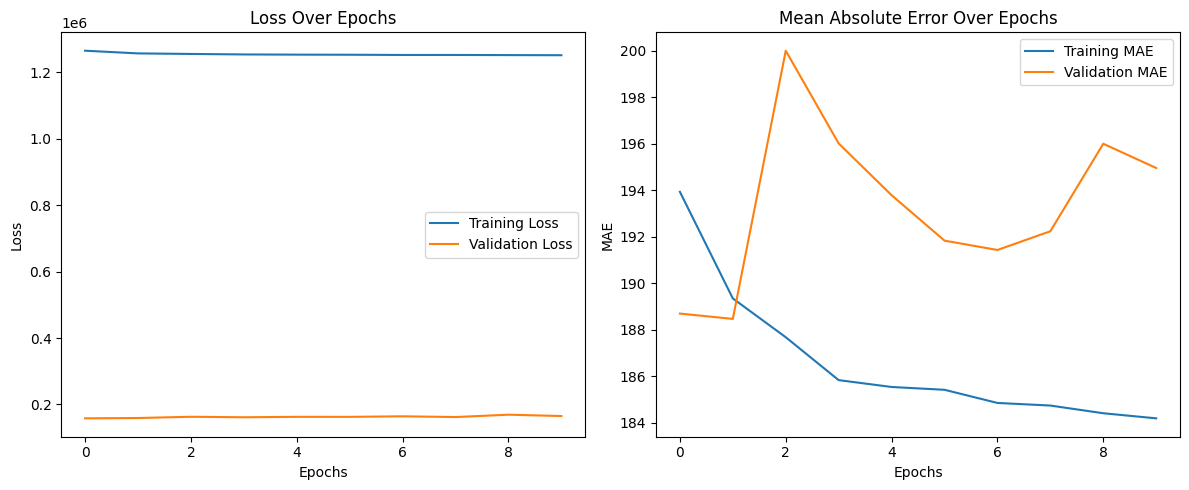

Generating iterative predictions for validation data...
Calculating evaluation metrics...
Validation Latitude/Longitude RMSE: 37.299
Validation Latitude/Longitude MAE: 24.485
Validation Latitude/Longitude Median AE: 18.211
Mean Haversine Distance: 1773880.622 meters
Median Haversine Distance: 997220.376 meters
Saving predictions...
Predictions saved to: ../data/processed/predictions\best_dl_model_predictions.csv


In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
from geopy.distance import geodesic
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Conv1D, Flatten, LSTM
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Ensure output directory exists
predictions_dir = '../data/processed/predictions'
os.makedirs(predictions_dir, exist_ok=True)

# Define a physics-informed loss function
def physics_informed_loss(y_true, y_pred):
    true_displacement = y_true[:, 0]
    pred_displacement = y_pred[:, 0]
    true_energy = 0.5 * tf.square(true_displacement)
    pred_energy = 0.5 * tf.square(pred_displacement)
    energy_loss = tf.reduce_mean(tf.abs(true_energy - pred_energy))  # Physical constraint
    mse_loss = tf.keras.losses.MeanSquaredError()(y_true, y_pred)  # Standard MSE loss
    total_loss = mse_loss + 0.1 * energy_loss  # Weighted combination
    return total_loss

# Randomly select 5 buoys for validation
print("Selecting 5 random buoys for validation...")
np.random.seed(42)
validation_buoys = np.random.choice(X['BuoyID'].unique(), size=5, replace=False)
print(f"Selected validation buoys: {validation_buoys}")

# Split the data into training and validation based on BuoyID
print("Splitting data into training and validation sets...")
train_data = X[~X['BuoyID'].isin(validation_buoys)].copy()
val_data = X[X['BuoyID'].isin(validation_buoys)].copy()

# Align `y` with `X`
y_train = y.loc[train_data.index]
y_val = y.loc[val_data.index]

# Verify alignment
assert train_data.shape[0] == y_train.shape[0], "Train data and target size mismatch."
assert val_data.shape[0] == y_val.shape[0], "Validation data and target size mismatch."

print(f"Training data size: {train_data.shape[0]} rows")
print(f"Validation data size: {val_data.shape[0]} rows")

# Drop 'BuoyID' and 'datetime' for training
X_train_clean = train_data.drop(columns=['BuoyID', 'datetime'])
X_val_clean = val_data.drop(columns=['BuoyID', 'datetime'])

# Convert to NumPy for deep learning models
X_train = X_train_clean.to_numpy()
X_val = X_val_clean.to_numpy()
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()

# Reshape for CNN or RNN models
if best_model_row['Model'] in ['CNN', 'RNN']:
    X_train = X_train.reshape(-1, 4, 1)
    X_val_reshaped = X_val.reshape(-1, 4, 1)
else:
    X_val_reshaped = X_val  # Keep as is for other models

# Load the best deep learning model architecture
print(f"Loading the best model: {best_model_row['Model']}...")
if best_model_row['Model'] == 'FCN':
    best_model = Sequential([
        Input(shape=(4,)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(2)
    ])
elif best_model_row['Model'] == 'CNN':
    best_model = Sequential([
        Input(shape=(4, 1)),
        Conv1D(32, kernel_size=2, activation='relu'),
        Conv1D(64, kernel_size=2, activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(2)
    ])
elif best_model_row['Model'] == 'RNN':
    best_model = Sequential([
        Input(shape=(4, 1)),
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dense(2)
    ])

# Compile the best model
optimizer = Adam(learning_rate=1e-3)
best_model.compile(optimizer=optimizer, loss=physics_informed_loss, metrics=['mae'])

# Train the model and track metrics
print("Training the model...")
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val_reshaped, y_val),
    batch_size=32,
    epochs=10,
    verbose=1
)
print("Model training completed.")

# Plot the loss and MAE over epochs
print("Plotting training history...")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot loss
ax[0].plot(history.history['loss'], label='Training Loss')
ax[0].plot(history.history['val_loss'], label='Validation Loss')
ax[0].set_title('Loss Over Epochs')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plot MAE
ax[1].plot(history.history['mae'], label='Training MAE')
ax[1].plot(history.history['val_mae'], label='Validation MAE')
ax[1].set_title('Mean Absolute Error Over Epochs')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('MAE')
ax[1].legend()

plt.tight_layout()
plt.show()

# Generate predictions using iterative predictor
print("Generating iterative predictions for validation data...")
predictions_df = iterative_prediction(
    val_data=val_data,
    model=best_model,
    tree=tree,
    valid_times=valid_time_dt,
    latitudes=latitudes,
    longitudes=longitudes,
    lat_lon_pairs=lat_lon_pairs
)

# Calculate evaluation metrics
print("Calculating evaluation metrics...")
true_lat_lon = predictions_df[['True Latitude', 'True Longitude']].to_numpy()
pred_lat_lon = predictions_df[['Predicted Latitude', 'Predicted Longitude']].to_numpy()

lat_lon_rmse = np.sqrt(mean_squared_error(true_lat_lon, pred_lat_lon))
lat_lon_mae = mean_absolute_error(true_lat_lon, pred_lat_lon)
lat_lon_median_ae = median_absolute_error(true_lat_lon, pred_lat_lon)

haversine_distances = [
    geodesic(true, pred).meters for true, pred in zip(true_lat_lon, pred_lat_lon)
]
mean_haversine_distance = np.mean(haversine_distances)
median_haversine_distance = np.median(haversine_distances)

print(f"Validation Latitude/Longitude RMSE: {lat_lon_rmse:.3f}")
print(f"Validation Latitude/Longitude MAE: {lat_lon_mae:.3f}")
print(f"Validation Latitude/Longitude Median AE: {lat_lon_median_ae:.3f}")
print(f"Mean Haversine Distance: {mean_haversine_distance:.3f} meters")
print(f"Median Haversine Distance: {median_haversine_distance:.3f} meters")

# Save predictions
print("Saving predictions...")
predictions_file = os.path.join(predictions_dir, 'best_dl_model_predictions.csv')
predictions_df.to_csv(predictions_file, index=False)
print(f"Predictions saved to: {predictions_file}")